In [ ]:
%%writefile generate_timeline.py
import re
import svgwrite
from collections import OrderedDict
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from subprocess import check_output

from config import configuration


from svgwrite import Drawing
from svgwrite.shapes import Rect, Circle
from svgwrite.text import Text
from svgwrite_title import Title


def getsvgcolors():
    kelly_colors = OrderedDict([
        ('vivid_yellow', (255, 179, 0)),
        ('strong_purple', (128, 62, 117)),
        ('vivid_orange', (255, 104, 0)),
        ('very_light_blue', (166, 189, 215)),
        ('vivid_red', (193, 0, 32)),
        ('grayish_yellow', (206, 162, 98)),
        ('medium_gray', (129, 112, 102)),

        # these aren't good for people with defective color vision:
        ('vivid_green', (0, 125, 52)),
        ('strong_purplish_pink', (246, 118, 142)),
        ('strong_blue', (0, 83, 138)),
        ('strong_yellowish_pink', (255, 122, 92)),
        ('strong_violet', (83, 55, 122)),
        ('vivid_orange_yellow', (255, 142, 0)),
        ('strong_purplish_red', (179, 40, 81)),
        ('vivid_greenish_yellow', (244, 200, 0)),
        ('strong_reddish_brown', (127, 24, 13)),
        ('vivid_yellowish_green', (147, 170, 0)),
        ('deep_yellowish_brown', (89, 51, 21)),
        ('vivid_reddish_orange', (241, 58, 19)),
        ('dark_olive_green', (35, 44, 22))])
    while True:
        for color in kelly_colors.values():
            yield "rgb({}, {}, {})".format(*color)
        print("WARNING: repeating colors")

        
def read_commits():
    result = check_output(["git", "log", "--use-mailmap", "--reverse"]).decode("utf8").split("\n")

    commit = []
    for line in result:
        if line.startswith("commit ") and commit:
            yield Commit(commit)
            commit = []
        commit.append(line)
    if commit:
        yield Commit(commit)


class Commit(object):
    
    def __init__(self, commit):
        delta = 0
        if commit[1].startswith('Merge: '):
            delta += 1
        self.author, self.email = re.findall(r"Author: (.*) <(.*)>", commit[1 + delta])[0]
        self.date = datetime.strptime(re.findall(r"Date: (.*)", commit[2 + delta])[0].strip(), '%c %z')
        self.hash = commit[0].split(" ")[1]
        self.message = '\n'.join(commit[4 + delta:])
        
    def draw(self, builder):
        color = builder.authors[self]
        circle = Circle(builder.position(self.date, builder.y), 5, fill=color)
        circle.add(Title(str(self)))
        return [circle]
    
    def __getitem__(self, key):
        return getattr(self, key)
    
    def __str__(self):
        return "{0.hash}\n{0.author} <{0.email}>\n{0.date}".format(self)
    
    
class AuthorList(object):
    
    def __init__(self):
        self.authors = {}
        self.color_generator = getsvgcolors()
        
    def __getitem__(self, item):
        email, blank = item if isinstance(item, tuple) else (item, None)
        email = email["email"] if isinstance(email, Commit) else email
        if email not in self.authors:
            self.authors[email] = (
                next(self.color_generator)
                if blank is None else blank
            )
        return self.authors[email]

    
class Builder(object):
    
    def __init__(self, name, commits, configuration, deltax=50.0, width=700.0, y=40.0, sep=20.0, image_size=40.0):
        self.commits = commits
        self.authors = AuthorList()
        self.initial_last_dates(configuration)
        self.position_function()
        height = y + sep + (self.max_elements + 1) * (image_size + sep)
        self.dwg = Drawing(name, size=(width + 2 * deltax, height))
        
        self.deltax = deltax
        self.width = width
        self.y = y
        self.sep = sep
        self.image_size = image_size
        
    def initial_last_dates(self, configuration):
        self.initial = self.commits[0]["date"]
        self.last = self.commits[-1]["date"]
        self.max_elements = 0

        for date_tuple, elements in configuration.items():
            date = datetime(*date_tuple).replace(tzinfo=timezone.utc)
            self.last = max(self.last, date)
            self.initial = min(self.initial, date)
            self.max_elements = max(self.max_elements, len(elements))
            
    def position_function(self):
        size = self.last.timestamp() - self.initial.timestamp()
        def position(date, y, deltax=0, deltay=0):
            return (self.deltax + (date.timestamp() - self.initial.timestamp()) / size * self.width + deltax, y + deltay)
        self.position = position
        
    def add(self, element):
        for xml in element.draw(self):
            self.dwg.add(xml)
            
    def save(self):
        self.dwg.save()

            
class Timeline(object):
    
    def draw(self, builder):
        return [Rect(
            (builder.deltax / 2, builder.y - 1),
            (builder.width + builder.deltax, 2))
        ]
    
    
class TimelineText(object):
    
    def __init__(self, date):
        self.date = date
        
    def draw(self, builder):
        text1 = svgwrite.text.Text(self.date.strftime("%b"),
                                   builder.position(self.date, builder.y - 36, deltax=-17),
                                   style="font-family:monospace")
        text2 = svgwrite.text.Text(self.date.strftime("%Y"), 
                                   builder.position(self.date, builder.y - 20, deltax=-20),
                                   style="font-family:monospace")
        return [text1, text2]

        
def create_timeline(file):
    commits = list(read_commits())
    builder = Builder(file, commits, configuration, y=60, sep=15, image_size=40)

    builder.add(Timeline())
    for i, commit in enumerate(commits):
        builder.add(commit)

    for date_tuple, elements in configuration.items():
        date = datetime(*date_tuple).replace(tzinfo=timezone.utc)
        for i, element in enumerate(elements):
            builder.add(element.position(date, builder.sep + i * (builder.image_size + builder.sep)))

    initial, last = builder.initial, builder.last    
    builder.add(TimelineText(initial))
    builder.add(TimelineText(last))

    for year in range(initial.year + 1, initial.year + 2 + relativedelta(last, initial).years):
        builder.add(TimelineText(datetime(year, 1, 1)))

    builder.save()
    
if __name__ == "__main__":
    import sys
    name = sys.argv[1] if len(sys.argv) > 2 else "history.svg"
    create_timeline(name)
        

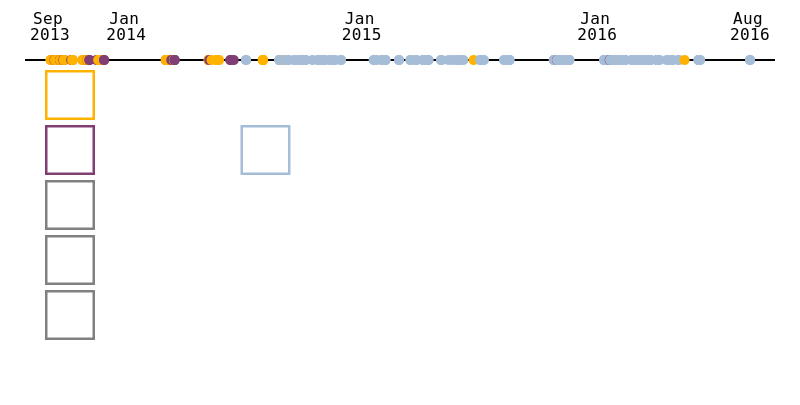

In [1]:

from generate_timeline import create_timeline
    
create_timeline("test.svg")
from IPython.display import SVG
SVG("test.svg")

In [ ]:
ip = get_ipython()

In [ ]:
ip.getoutput??